# Fashion-MNIST を使ったClassification

fashion-MNIST データセットを使って画像のclassificationを行います

## Dataset の確認

今回はオープンデータのfashion-MNISTを使うので、中身を確認します

データの大元はここにあります。
https://github.com/zalandoresearch/fashion-mnist

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

(X_train_orig, y_train_orig), (X_test_orig, y_test_orig) = fashion_mnist.load_data()

## それぞれのデータ形を表示してみましょう
print("train feature shape", X_train_orig.shape)
print("train label shape", y_train_orig.shape)
print("test feature shape", X_test_orig.shape)
print("test label shape", y_test_orig.shape)

train feature shape (60000, 28, 28)
train label shape (60000,)
test feature shape (10000, 28, 28)
test label shape (10000,)


訓練データは60,000件、テストデータは10,000件で、画像のshapeは(28, 28)であることがわかります。
また、縦横の2次元しかないため、色は白黒のグレースケール画像であることがわかります。

featureとなる画像データを見てみると様々なファッションアイテムの画像が入っています。

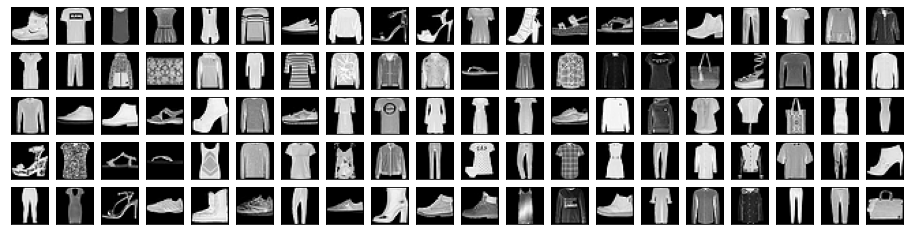

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def show(n_cols, n_rows, train_orig):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(16,4))
    for ax, pixels in zip(axs.flat, train_orig):
        ax.imshow(pixels, cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

show(20, 5, X_train_orig)

labelの意味は https://github.com/zalandoresearch/fashion-mnist#labels ここにあります。

次に、ラベル毎の画像データの数をグラフで表示してみましょう。

<BarContainer object of 10 artists>

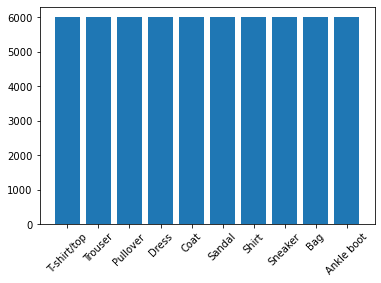

In [3]:
import numpy as np

labels = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
]
left = range(0, 10)
height = np.zeros(10)
for v in y_train_orig:
    height[v] += 1
    
plt.xticks(rotation=45)
plt.bar(left, height, tick_label=labels, align="center")

結果から、データはそれぞれのカテゴリごとに6,000件ずつ、均等にはいっているようです。

これでデータについてはわかったので、モデルを作成するための準備に取り掛かります。

## data preprocessing

モデルを作成するにあたって、データの前処理を行います。
ここでは3つの処理を行っています。
- kerasのcnnで使用するメソッドであるConv2Dは入力のshapeとして(batch_size, rows, cols, channels)を取るため、データをexpandします。(channelsはカラーモードに相当)
- データの正規化を行います。 (値の範囲を[0-255]から[0-1]にします。)
- ラベルをone hot表現に変換します。('Trouser'が正解の場合、[0,1,0,0,0,0,0,0,0,0]になります。)

In [4]:
## shapeを(batch_size, rows, cols, channels)にexpandする。 (batch_sizeはtrainning時に指定するため、現時点では全データ数を指定)
X_train = np.expand_dims(X_train_orig, -1)
X_test = np.expand_dims(X_test_orig, -1)

print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)

## グレースケールの 0-255 の値を 正規化して 0-1 の浮動小数にする
X_train = X_train / 255.0
X_test = X_test / 255.0

## one hot vectorにする
y_train = tf.keras.utils.to_categorical(y_train_orig, 10)
y_test = tf.keras.utils.to_categorical(y_test_orig, 10)

print("one hot label shape", y_train.shape)

X_train shape (60000, 28, 28, 1)
X_test shape (10000, 28, 28, 1)
one hot label shape (60000, 10)


問題なく前処理が行えたら、モデルを構築していきます。

## model

kerasでmodelを作成する場合には2つの方法があります。 Sequential API を使う方法と、Funcional API を使う方法です。

Sequential APIはシンプルで単純な構造のmodelを作る際に便利で、Functional APIは複数の入力やアウトプットをもったり、内部で分岐処理があるような複雑なモデルを作成する際に向いています。
今回はSequential APIを用いてmodelを作ってみましょう

スライドや https://www.tensorflow.org/api_docs/python/tf/keras/layers 
https://keras.io/examples/vision/mnist_convnet/ の`Build the model`などを参考にcnnを使ってmodelを組んでみましょう

In [5]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

def cnn():
    model = tf.keras.Sequential()
    model.add(Conv2D(32, kernel_size = (3,3), activation = "relu"))
    model.add(Conv2D(64, kernel_size = (3,3), activation = "relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, kernel_size = (3,3), activation = "relu"))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = "softmax"))
    return model

モデルができたら、いよいよモデルの学習に取り掛かっていきます。

## training: 訓練

では、モデルを学習させて、ついでにモデルの中身を見てみましょう

In [6]:
%rm -rf ./logs

model = cnn()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tf.keras.metrics.CategoricalAccuracy()])
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.1, callbacks=[tensorboard_callback])

2022-04-24 09:02:56.034780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 09:02:56.045235: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 09:02:56.045873: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 09:02:56.047651: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/10


2022-04-24 09:02:58.103567: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


1688/1688 [==============================] - 10s 4ms/step - loss: 0.5023 - categorical_accuracy: 0.8208 - val_loss: 0.3266 - val_categorical_accuracy: 0.8758
Epoch 2/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.3236 - categorical_accuracy: 0.8846 - val_loss: 0.2585 - val_categorical_accuracy: 0.9063
Epoch 3/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2799 - categorical_accuracy: 0.9009 - val_loss: 0.2361 - val_categorical_accuracy: 0.9122
Epoch 4/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2513 - categorical_accuracy: 0.9091 - val_loss: 0.2184 - val_categorical_accuracy: 0.9193
Epoch 5/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2274 - categorical_accuracy: 0.9180 - val_loss: 0.2092 - val_categorical_accuracy: 0.9243
Epoch 6/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2072 - categorical_accuracy: 0.9247 - val_loss: 0.2150 - val_categorical_accuracy: 0.9238
Ep

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 dropout (Dropout)           (None, 10, 10, 64)        0         
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                        

訓練の経過や中身はどうだったでしょうか？　意図した通りのモデルが組まれており、学習も問題なく進んでいっていたでしょうか？

## test: 検証

訓練が終わったので、訓練データには存在しないデータで検証をしていきます

In [8]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.2317 - categorical_accuracy: 0.9279


[0.23173607885837555, 0.9279000163078308]

表示されている情報はテスト時のlossとcategorical_accuracyです。訓練の結果とどの程度違いがあったでしょうか？ overfitはしていないでしょうか？

## tensorboardでの可視化
また、tensorboardを使うことによって訓練結果の可視化をしてみましょう

In [9]:
%load_ext tensorboard

In [10]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 26078), started 0:34:52 ago. (Use '!kill 26078' to kill it.)

学習推移がtensorboardで表示されたでしょうか。

## prediction: 推論

では出来上がったmodelにリクエストを投げて実際に処理を行ってみましょう

0 Coat 99.79313611984253%
1 Sandal 99.98761415481567%
2 Sneaker 88.7887179851532%
3 Dress 99.99983310699463%
4 Coat 96.11481428146362%
5 Trouser 100.0%
6 Pullover 98.75571727752686%
7 Coat 74.56443309783936%
8 Bag 100.0%
9 T-shirt/top 99.99527931213379%


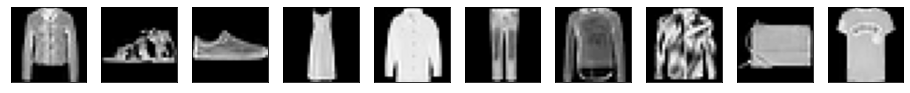

In [11]:
predictions = model.predict(X_test[10:20])
for i, p in enumerate(predictions):
    print(i, labels[np.argmax(p)], "{}%".format(p[np.argmax(p)]*100))
show(10, 1, X_test_orig[10:20])

## 保存

出来上がったモデルは現時点では、notebookのメモリ上にしかありません。これを保存します。  
save_formatはtensorflow2.0以降のデフォルトの保存形式になっているsaved_model形式で保存を行うための指定です。

In [12]:
USER    = "username" # 自分の名前
BUCKET  = "mixi-ml-handson-2022"
VERSION = "001"

model.save("gs://{}/{}/{}".format(BUCKET, USER, VERSION), save_format="tf")

2022-04-24 09:06:41.916993: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: gs://mixi-ml-handson-2022/rio/001/assets


# 追加課題

+ modelの構成を変更して、どのくらい性能が変わるか確認してみよう
  + Dropoutの有無、正規化の有無、CNNからDNNにした場合
+ 時間に余裕がある場合は 01ex_pruningに進もう